### Python Script to Compute Mann Kendall trends written by Herbert. O. Misiani and modified by Samuel Ekwacu

### Computing persistent hot spell events trends over Africa-Seasonal

In [152]:
## libraries to install for first time 
#conda install -c conda-forge regionmask
# conda install -c conda-forge geopandas
#conda install -c conda-forge descartes
#conda install -c conda-forge pymannkendall
#conda install -c conda-forge cartopy
#conda install -c conda-forge pyogrio
#conda install -c conda-forge xeofs
#conda install -c conda-forge r-correlation
#conda install -c conda-forge pytest-regressions

In [186]:
import pymannkendall as mk
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import matplotlib.path as mplPath
## for plotting a polygon
from shapely.geometry.polygon import Polygon
import geopandas as gpd
import shapefile as shp
import regionmask

In [187]:
#uploaded.keys()
#home_dir = 'D:/Folder_2023/Research/' ## read in the data
#data_dir = 'Africa_Research/Hotspell_Africa/tmean_analysis/'
#plot_dir = 'Africa_Research/Hotspell_Africa/trend_plots/tmean_plots/'
#temp = xr.open_dataset(home_dir + data_dir + 'JRA55-tmean-monthly_v3_1991-2021.nc')  ##input file                          
temp = xr.open_dataset('C:/ERSSTv5/sst.mnanom_1991-2021.nc')
#temp
#temp[10,:,:]

In [188]:
###########NOTE; Change appropriately below to compute either annual or Seasonal trends #########

###For Annual Trends Only
Data=temp['sst'].groupby('time.year').mean('time')    ## Group data into yearly means for annual trends
#Data[10,:,:]

### For Seasonal trends of MAM, JJA, SON and DJF only
#Data_seas = temp.groupby('time.season')   ##Group data into seasonal means for seasonal trends
#Data_seas
#Data_sea = Data_seas['DJF']
#Data_sea
#Data = Data_sea['tmean'].groupby('time.year').mean('time') ## Group data into yearly means from seasonal mean.
#Data

In [189]:
#dat_samp = Data.sel(lon=slice(27.5, 42.5), lat=slice(-12, 5))  ## Slice to EA
#dat_samp = Data.sel(Lon=slice(-20, 55), Lat=slice(-35, 40))  ## Slice to Africa
dat_samp =Data
slope_val = np.zeros((len(dat_samp.lat.values),len(dat_samp.lon.values)))
p_value = np.zeros((len(dat_samp.lat.values),len(dat_samp.lon.values)))
#output = []
for i in np.arange(len(dat_samp.lat.values)):
    for j in np.arange(len(dat_samp.lon.values)):
        
        try:
            slope_val[i,j] = mk.original_test(dat_samp[:,i,j]).slope  ## trend,h,p,z,tau,s,var_s,slope,intercept = mk.original_test(x,0.05)
            p_value[i,j] = mk.original_test(dat_samp[:,i,j]).p
        except:
            slope_val[i,j] = np.nan
            p_value[i,j] = np.nan
            
        #output.append(slope_val)

In [190]:
## Define data as Xarray dataset and save as netcdf
output1=xr.DataArray(slope_val, dims=('lat', 'lon'), coords={'lat':dat_samp.lat, 'lon':dat_samp.lon}, attrs=dict(description="slope.", units="sst year-1"),)
data1 = output1.rename("trend")

output2=xr.DataArray(p_value, dims=('lat', 'lon'), coords={'lat':dat_samp.lat, 'lon':dat_samp.lon}, attrs=dict(description="significance",),)
data2 = output2.rename("p_val")
#data2
## Save Data as netcdf
#data1.to_netcdf(home_dir + data_dir +'Af_tmean_1991-2021_Annual_trend.nc', mode='w')
#data2.to_netcdf(home_dir + data_dir +'Af_tmean_1991-2021_Annual_pvalue.nc', mode='w')

In [191]:
## read the Shapefile of the Area of interest for use in masking over the required region
#sf = gpd.read_file('F://Folder_2022//Research//EA_Shp//East_Africa-Disolved.shp')  ## Used in Masking
#sf2 = shp.Reader('F://Folder_2022//Research//EA_Shp//EA.shp')       ## Used in plotting

#sf = gpd.read_file('D://Folder_2023//Research//Africa_Research//shapefile//Africa_admin1.shp')  ## Used in Masking
#sf2 = shp.Reader('F://Folder_2022//Research//Africa_Research//shapefile//Africa_admin1.shp')       ## Used in plotting

## Mask the trends and p_values
#trend_mask = regionmask.mask_3D_geopandas(sf, data1.Lon, data1.Lat, lon_name='Lon', lat_name='Lat')
#pval_mask = regionmask.mask_3D_geopandas(sf, data2.Lon, data2.Lat, lon_name='Lon', lat_name='Lat')
#trnd = data1.where(trend_mask)         ## clip the data with the mask
#pval = data2.where(pval_mask)

In [192]:
trnd = data1        ## clip the data with the mask
pval = data2

In [193]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

C:\Users\Samuel-NUIST\AppData\Local\Temp\ipykernel_8968\205630846.py:34: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(bottom=0.08, right=0.8, top=0.8)


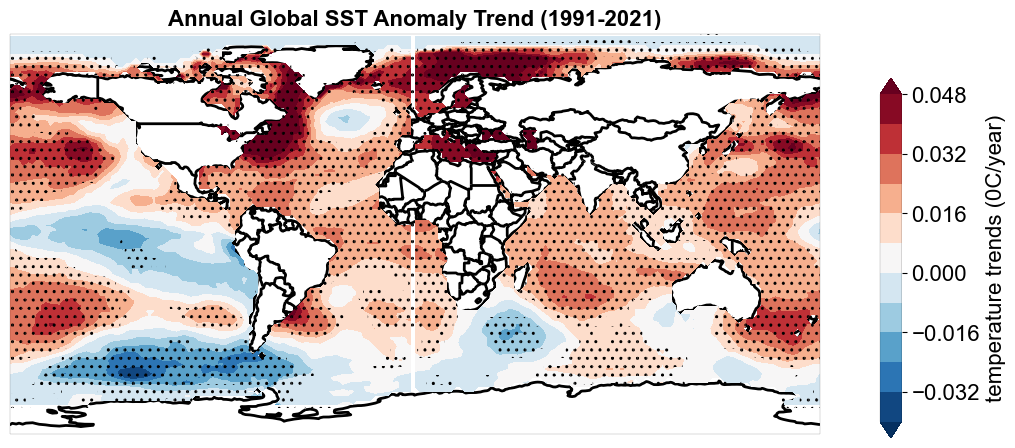

In [196]:
#plot variables
fig, ax = plt.subplots(constrained_layout=True, figsize=(12, 6))
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=0))
#projection = ccrs.PlateCarree(central_longitude=-180)
ax.add_feature(cfeature.COASTLINE, linewidth=2)
ax.add_feature(cfeature.BORDERS, linewidth=2)

               
## Change this to the threshold you need.
#cond = (pval >= -0.05) & (pval <= 0.05)
cond = (pval <= 0.05)
## Mask out the areas that do not satisfy the conditions
sig_reg = pval.where(cond)

## Plotting the figure
#for poly in sf2.shapes():
 #   poly_geo=poly.__geo_interface__
 #   ax.add_patch(PolygonPatch(poly_geo, fc='None', ec='black', alpha=1, fill='False', zorder=2))

cs = plt.contourf(dat_samp.lon, dat_samp.lat, trnd.values[:,:],  
               levels=np.arange(-0.04, 0.05, 0.008), cmap=plt.cm.RdBu_r, extend='both') #RdBu #YlOrRd,YlOrBr,YlOrBr  #levels=np.arange(-9, 12, 3)
## make a hatch of significance  RdYlBu_r
hatch = ax.pcolor(dat_samp.lon, dat_samp.lat, sig_reg.data[:,:], cmap=none_map, 
                 hatch='..', edgecolor='black', lw=0, zorder=4)
## title attributes
plt.title('Annual Global SST Anomaly Trend (1991-2021)',fontsize=16, fontweight='bold')
plt.xticks(size = 12, fontweight='bold')
plt.yticks(size = 12, fontweight='bold')
#plt.xticks(fontsize=12, fontweight='bold')
##labling the axis
plt.ylabel('Latitude',fontsize=14, fontweight='bold')
plt.xlabel('Longitude',fontsize=14, fontweight='bold')
##ploting the legend
plt.subplots_adjust(bottom=0.08, right=0.8, top=0.8)
#####cax = plt.axes([0.85, 0.1, 0.018, 0.6])s
###plt.colorbar(cax=cax)
fig.colorbar(cs, ax=ax,cax = plt.axes([0.85, 0.1, 0.018, 0.6]), label='temperature trends (0C/year)')
# save output
plt.savefig('C:/ERSSTv5/sst-anom_trend_1991-2021.png')
plt.show()

### God is Greate















